In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,10)
# %matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
pd.set_option('use_inf_as_na', True)
from collections import Counter

import os
import time

from scipy.cluster import hierarchy as hc
import scipy.stats

import statsmodels.api as sm

import concurrent.futures

# Problem 1

. Insert a column in the data set where the entries are 1 if the stock outperforms SPY
in the earnings period and -1 if it underperforms or has the same return.

Create a BaggingClassifier with a DecisionTreeClassifier with max_level = 6 and
n_estimators = 40 and the new column as labels.

Use the period 2007-2010 to train the model on the data set constructed above and
construct a set of features that optimizes the profit of the long-short strategy on the
quarter 2009-07-30 – 2009-10-30

Backtest the performance of the model with the optimal features over the period
2010 – 2018.

Compute Sharpe Ratio, Information Ratio and alpha for the strategy and for the
buy-and-hold strategy for SPY

Change hyper parameters for the BaggingClassifier and the DecisionTree and try
at least 3 combinations of max_depth and n_estimators. Find optimal features and
backtest with each of the combinations of hyperparameters. 

In [2]:
def bag_decision_classifier(a):
    max_l=a[0]
    n_est=a[1]
    question=a[2]
    debug = False
    timing = True
    if timing:
        st = time.time()
        print("starting decision classifier")
        
    raw_data = pd.read_pickle(os.path.join(os.path.dirname(os.getcwd()), "data/dataset.pkl"))
    data = raw_data[raw_data['market_cap'] > 1000.0]
    data = data.copy()
    data.fillna(0.0,inplace=True)
    
    if question==1:
        data['rel_performance'] = np.where((data["pred_rel_return"] > 0), 1, -1)
    elif question==2:
        tranche_spy = np.zeros(len(data))
        tranches = [0.01, 0.05] # Add tranches as you please
        for t in tranches:
            tranche_spy += np.where(data["pred_rel_return"]>t, 1, 0)
            tranche_spy += np.where(data["pred_rel_return"]<-t, -1, 0)

        data['rel_performance'] = tranche_spy.astype(int)

    data.reset_index(inplace=True,)
    data.set_index('date',inplace=True)
    
    df_2 = data.loc['2007-01-01':'2010-12-31']
    df_valid_2 = data.loc['2009-07-30':'2009-10-30']
    df_test_2 = data.loc['2010-01-01':'2018-12-31']
    
    to_drop = ['ticker','date',
               'next_period_return',
               'spy_next_period_return', 'fqtr_2',
               'rel_performance','pred_rel_return',
               'return', 'cum_ret', 'spy_cum_ret']
    
    train_2 = df_2.reset_index().drop(to_drop,axis=1)

    valid_2 = df_valid_2.reset_index().drop(to_drop,axis=1)
    test = df_test_2.reset_index().drop(to_drop,axis=1)
    
    valid_2_stock_returns = df_valid_2['next_period_return']
    train_2_stock_returns = df_2['next_period_return']
    test_stock_returns = df_test_2['next_period_return']
    
    y_2 = df_2['rel_performance']
    y_valid_2 = df_valid_2['rel_performance']
    y_test_2 = df_test_2['rel_performance']
    
    y_2 = y_2.values
    y_valid_2 = y_valid_2.values
    y_test_2 = y_test_2.values
    
    if debug: print("built data")
    
    t_clf = DecisionTreeClassifier(max_depth=max_l,min_samples_leaf=800, random_state=np.random.randint(1000))
    
    bg_clf = BaggingClassifier(t_clf,n_estimators=n_est,oob_score=True,random_state=np.random.randint(1000),n_jobs=1)
    
    if debug: print("fitting tree")
    
    bg_clf.fit(train_2,y_2)
    
#     bg_clf.score(train_2,y_2)
    
#     bg_clf.score(valid_2,y_valid_2)
    
    pred_valid = bg_clf.predict(valid_2)
    
#     Counter(pred_valid)
    
#     Counter(y_valid_2)
    
#     bg_clf.oob_score_
    
#     confusion_matrix(y_valid_2,pred_valid)
    
    def baggingtree_feat_importance(m, df):
        feature_importances = []
        for est in m.estimators_:
            fi = est.feature_importances_
            feature_importances.append(fi)
        feature_importances = np.array(feature_importances)

        return pd.DataFrame({'cols':df.columns, 'feat_imp':np.mean(feature_importances,axis=0)}
                           ).sort_values('feat_imp', ascending=False)

    def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(12,7), legend=False)
    
    fi = baggingtree_feat_importance(bg_clf,train_2)
    
    features = fi[(fi['feat_imp'] > 0.01)]
#     features
    
#     plot_fi(features);
    
    train_2 = train_2[features['cols'].values]
    valid_2 = valid_2[features['cols'].values]
    
    bg_clf.fit(train_2,y_2)
    bg_clf.score(train_2,y_2)
    
    pred_valid = bg_clf.predict(valid_2)
    bg_clf.score(valid_2,y_valid_2)
    
    def profit_importance(t,df,rets):
    #     np.random.seed(123)
        profit = []
        for col in df.columns:
                prof = []
                for _ in range(20):
                    X = df.copy()
                    X[col] = np.random.permutation(df[col].values)
                    prediction = t.predict(X)
                    prof.append((prediction * rets).sum())
                profit.append(np.mean(prof))
        return profit
    
    def baggingtree_profit_importance(m, df,rets):
        return pd.DataFrame({'cols':df.columns, 'pi_imp':profit_importance(m,df,rets)}
                           ).sort_values('pi_imp', ascending=True)
    
    pi = baggingtree_profit_importance(bg_clf,valid_2,df_valid_2['next_period_return'])
#     pi
    
    profits = []

    feat=[]

    train = train_2.copy()
    validation = valid_2.copy()
    
#     fi = baggingtree_feat_importance(bg_clf,train)
#     features = fi[(fi['feat_imp'] > 0.01)]
    
    train = train[features['cols'].values]
    validation = validation[features['cols'].values]
    
    if debug: print("columns stuff")

    while len(train.columns)>1:

        bg_clf.fit(train,y_2)
        pi = baggingtree_profit_importance(bg_clf,validation,y_valid_2)

        col_to_drop = pi[pi['pi_imp'] == pi['pi_imp'].max()]['cols'].iloc[0]
        train.drop(col_to_drop,axis=1,inplace=True)
        validation.drop(col_to_drop,axis=1,inplace=True)
        bg_clf.fit(train,y_2)

        fi = baggingtree_feat_importance(bg_clf,train)
        features = fi[(fi['feat_imp'] > 0.00)]
        train = train[features['cols'].values]
        validation = validation[features['cols'].values]
        bg_clf.fit(train,y_2)

        pred_valid = bg_clf.predict(validation)
        profits.append((pred_valid * df_valid_2['next_period_return']).sum())
        if debug: print((pred_valid * df_valid_2['next_period_return']).sum())
        feat.append(features['cols'].values) 
    
    n = np.argmax(profits)
    optim_feats = feat[n]
    max_profits = profits[n]
    
    train_2_optim = train_2[optim_feats]
    valid_optim = valid_2[optim_feats]
    
    print(f"{max_l},{n_est} optim_feats={optim_feats}")

    bg_clf.fit(train_2_optim,y_2)
    if debug: print(bg_clf.score(train_2_optim,y_2))
    pred_valid_tree = bg_clf.predict(valid_optim)
    if debug: print(bg_clf.score(valid_optim,y_valid_2))
    (pred_valid_tree * df_valid_2['next_period_return']).sum()

    train_2_tree = train_2[optim_feats]
    test_tree = test[optim_feats]
    bg_clf.fit(train_2_tree,y_2)
    pred_test_tree = bg_clf.predict(test_tree)
    (pred_test_tree * test_stock_returns).sum()

    start_dates = [pd.to_datetime('2007-01-01') + pd.DateOffset(months = 3 * i) for i in range(35)]
    end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

    training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
    test_frames = [data.loc[d + pd.DateOffset(months=3):d+pd.DateOffset(months = 6)] for d in end_dates]

    training_data = [d.reset_index().drop
                                     (['ticker','date',
                                       'next_period_return',
                                       'spy_next_period_return',
                                       'rel_performance','pred_rel_return',
                                      'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in training_frames]

    test_data = [d.reset_index().drop(['ticker','date',
                                       'next_period_return',
                                       'spy_next_period_return',
                                       'rel_performance','pred_rel_return',
                                      'return', 'cum_ret', 'spy_cum_ret'],axis=1) for d in test_frames]

    training_labels = [d['rel_performance'].values for d in training_frames]
    
    opt_training_data = [t[optim_feats] for t in training_data]
    opt_test_data = [v[optim_feats] for v in test_data]
    
#     print(training_labels)
    

    P_L = []
    x   = [1]
    ret = []
    
    if question==1:
        for i in range(len(training_labels)):
    #             print(i, opt_test_data[i])
                bg_clf.fit(opt_training_data[i],training_labels[i])
                pred_i = bg_clf.predict(opt_test_data[i])
                profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
                P_L.append(profit_i)
                num_positions = len(pred_i)
                ret.append((1.0/num_positions) * profit_i)
                x.append(x[i] + (x[i]/num_positions) * profit_i)
    
    elif question==2:
        for i in range(len(training_labels)):
                bg_clf.fit(opt_training_data[i],training_labels[i])
                pred_i = bg_clf.predict(opt_test_data[i])
                profit_i = (pred_i * test_frames[i]['next_period_return']).sum()
                P_L.append(profit_i)
                num_positions = len(pred_i)
                ret.append((1.0/num_positions) * profit_i)
                x.append(x[i] + (x[i]/sum(abs(pred_i))) * profit_i)
            
    if timing:
        print(f"Finished {a}: {time.time()-st:.2f}")
        
#     print(len(end_dates), len(x))
    
    return x

#### Use Multiprocessing to concurrently train classifiers

Question 2 requirements are also computed here.

In [3]:
st = time.time()

res = {}

with concurrent.futures.ProcessPoolExecutor() as exec:
    args = [(6, 40,1), (6, 60,1), (5, 40,1), (5,60,1), 
            (6, 40,2), (6, 60,2), (5, 40,2), (5,60,2)]
    results = exec.map(bag_decision_classifier, args)
    
    for k, r in zip(args, results):
        res[f"{k[0]},{k[1]},{k[2]}"] = r

print(f"{time.time()-st:.4f}")

starting decision classifier
starting decision classifier
starting decision classifier
starting decision classifier
starting decision classifier
starting decision classifierstarting decision classifierstarting decision classifier


5,40 optim_feats=['cf_yield' 'dvpspq' 'evmq' 'dpcy' 'market_cap' 'ibcomy']
6,40 optim_feats=['cf_yield' 'dprq' 'evmq' 'prccq' 'dlttq' 'dpcy' 'fcf_ocfq' 'ibcomy'
 'market_cap']
Finished (5, 40, 2): 231.98
Finished (6, 40, 2): 265.92
5,60 optim_feats=['cf_yield' 'evmq' 'dprq' 'prccq' 'dvq' 'oancfy' 'dlttq' 'dpcy'
 'market_cap' 'fcf_ocfq' 'ibcomy' 'dvpspq']
6,60 optim_feats=['cf_yield' 'evmq' 'dprq' 'prccq' 'dvq' 'oancfy' 'dlttq' 'dpcy'
 'market_cap' 'fcf_ocfq' 'ibcomy' 'dvpspq']
5,40 optim_feats=['cf_yield' 'evmq' 'totdebt_invcapq' 'sale_nwcq' 'profit_lctq'
 'intcov_ratioq' 'market_cap']
6,40 optim_feats=['cf_yield' 'evmq' 'sale_nwcq' 'profit_lctq' 'prccq']
Finished (5, 40, 1): 362.90
Finished (6, 40, 1): 395.59
Finished (5, 60, 2): 400.52
Finished (6, 60, 2):

<AxesSubplot:>

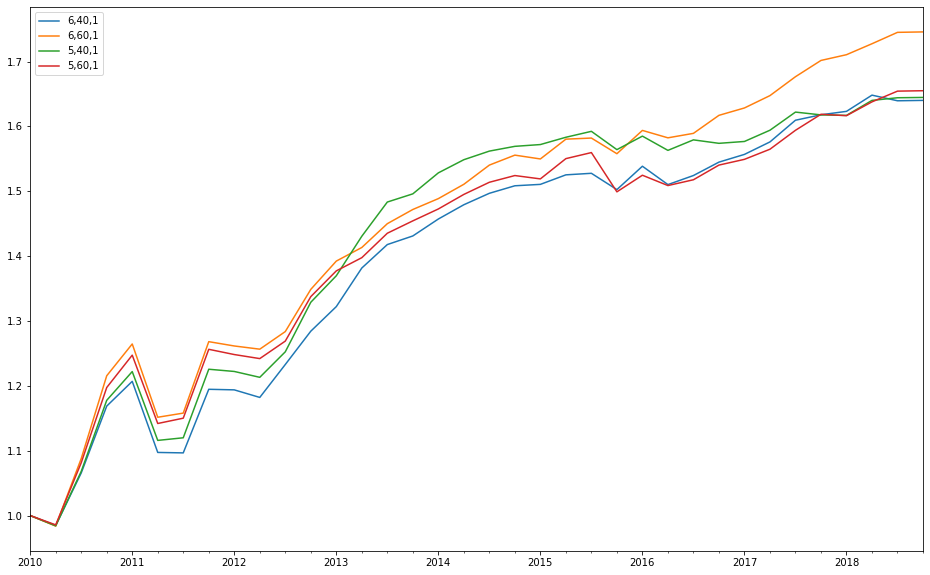

In [4]:
start_dates = [pd.to_datetime('2007-01-01') + pd.DateOffset(months = 3 * i) for i in range(36)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

qs = pd.DataFrame(res, index=end_dates)
qs.iloc[:,:4].plot()

In [5]:
spy = pd.read_pickle("spy_cum_ret.pkl")
spy = spy.resample('Q').ffill()
spy.index += pd.DateOffset(days=1)
spy = spy.diff()
spy = spy.loc[qs.index]

In [8]:
def portstats_bm(v, bm, nper=12):
    """Arguments:
    v: pd.DataFrame containing rows of returns OR
    bm: pd.DataFrame containing rows of returns
    nper: int for annualization
    """
    try:
        c = v.columns
    except AttributeError:
        c = ["Portfolio"]
    
    mu = v.mean() * nper
    sig = v.std() * np.sqrt(nper)
    
    alpha, rsq, mae, tr, ir, reg = [], [], [], [], [], []
    beta = {}
    for col in bm.columns:
        beta[col] = []
    
    for name, col in v.iteritems():
        res = sm.OLS(col, sm.add_constant(bm.values), missing="drop").fit()
        
        alpha.append(res.params[0] * nper)
        rsq.append(res.rsquared)
        mae.append(abs(res.params[0] * nper))
        for i, col in enumerate(bm.columns):
            beta[col].append(res.params[i+1])
        tr.append(mu[name] / res.params[1])
        ir.append(res.params[0] / res.resid.std() * np.sqrt(nper))
        reg.append(res)
    
    alpha = pd.Series(alpha, index=c)
    beta = pd.DataFrame(beta, index=c).T
    beta.index = ["beta_"+i for i in beta.index]
    mae = pd.Series(mae, index=c)
    tr = pd.Series(tr, index=c)
    ir = pd.Series(ir, index=c)
    
    ret = pd.DataFrame([mu, sig, mu / sig, alpha],
                       index=["mean", "std", "sharpe", "alpha"],
                       columns=c)
    end = pd.DataFrame([rsq, mae, tr, ir], index=["r2", "mae", "treynor", "info ratio"], columns=c)
    
    ret = pd.concat([ret, beta, end]).T
    return ret, reg

#### Sharpe Ratio, Info Ratio, and Alpha Question 1

In [11]:
ret, reg = portstats_bm(qs.iloc[:,:4].pct_change(), spy, nper=4)
ret

,mean,std,sharpe,alpha,beta_spy_cum_ret,r2,mae,treynor,info ratio
"6,40,1",0.059027,0.065702,0.898391,0.081242,-0.158330,0.075784,0.081242,-0.372806,1.286207
"6,60,1",0.066576,0.070995,0.937764,0.093163,-0.189485,0.092964,0.093163,-0.351352,1.377859
"5,40,1",0.059499,0.068324,0.870848,0.081533,-0.157039,0.068943,0.081533,-0.378883,1.236736
"5,60,1",0.060261,0.068931,0.874222,0.083427,-0.165110,0.074874,0.083427,-0.364974,1.258329


# Problem 2

Insert a column in the data set with entries: 2 if the stock return is more then 5%
higher than the SPY return, 1 if it is more than 1% but less than 5% higher, 0 if it
is between -1% and 1%, -2 if the stock underperforms the SPY by more than -5%
and -1 if the performance is between -1% and -5%

Same questions for this dataset as in problem 1 but where the strategy is to invest
$x where x is the predicted label

<AxesSubplot:>

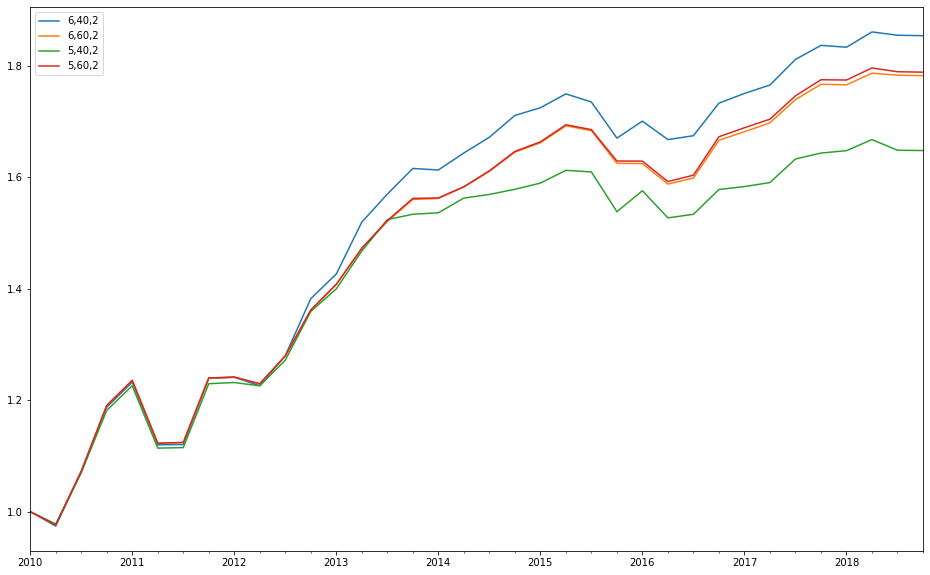

In [7]:
qs.iloc[:,4:].plot()

#### Sharpe Ratio, Info Ratio, and Alpha Question 2

In [13]:
ret, reg = portstats_bm(qs.iloc[:,4:].pct_change(), spy, nper=4)
ret

,mean,std,sharpe,alpha,beta_spy_cum_ret,r2,mae,treynor,info ratio
"6,40,2",0.074191,0.079183,0.936952,0.098135,-0.170654,0.060615,0.098135,-0.434744,1.278705
"6,60,2",0.069384,0.076166,0.910964,0.094776,-0.180968,0.073671,0.094776,-0.383407,1.292868
"5,40,2",0.060306,0.076416,0.789187,0.082284,-0.156637,0.054833,0.082284,-0.385005,1.107588
"5,60,2",0.069797,0.076245,0.915427,0.095574,-0.183719,0.075770,0.095574,-0.379910,1.303884
